In [1]:
from typing import Dict

from tempfile import gettempdir
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.models.resnet import resnet34
from tqdm import tqdm

from l5kit.configs import load_config_data
from l5kit.data import LocalDataManager, ChunkedDataset
from l5kit.dataset import AgentDataset, EgoDataset
from l5kit.rasterization import build_rasterizer
from l5kit.evaluation import write_pred_csv, compute_metrics_csv, read_gt_csv, create_chopped_dataset, read_pred_csv
from l5kit.evaluation.chop_dataset import MIN_FUTURE_STEPS
from l5kit.evaluation.metrics import neg_multi_log_likelihood, time_displace
from l5kit.geometry import transform_points
from l5kit.visualization import PREDICTED_POINTS_COLOR, TARGET_POINTS_COLOR, draw_trajectory
from prettytable import PrettyTable
from pathlib import Path

from torch import Tensor
from collections import OrderedDict, defaultdict


import os

## Prepare Data path and load cfg

By setting the `L5KIT_DATA_FOLDER` variable, we can point the script to the folder where the data lies.

Then, we load our config file with relative paths and other configurations (rasteriser, training params...).

In [7]:
DEBUG = False

# training cfg
validation_cfg = {
    
    'format_version': 4,
    
     ## Model options
    'model_params': {
        'model_architecture': 'resnet34',
        'history_num_frames': 10,
        'history_step_size': 1,
        'history_delta_time': 0.1,
        'future_num_frames': 50,
        'future_step_size': 1,
        'future_delta_time': 0.1,
    },

    ## Input raster parameters
    'raster_params': {
        
        'raster_size': [224, 224], # raster's spatial resolution [meters per pixel]: the size in the real world one pixel corresponds to.
        'pixel_size': [0.5, 0.5], # From 0 to 1 per axis, [0.5,0.5] would show the ego centered in the image.
        'ego_center': [0.25, 0.5],
        'map_type': "py_semantic",
        
        # the keys are relative to the dataset environment variable
        'satellite_map_key': "aerial_map/aerial_map.png",
        'semantic_map_key': "semantic_map/semantic_map.pb",
        'dataset_meta_key': "meta.json",

        # e.g. 0.0 include every obstacle, 0.5 show those obstacles with >0.5 probability of being
        # one of the classes we care about (cars, bikes, peds, etc.), >=1.0 filter all other agents.
        'filter_agents_threshold': 0.5
    },

    ## Data loader options
    'valid_data_loader': {
        'key': "scenes/validate_chopped_100/validate.zarr",
        'batch_size': 1,
        'shuffle': False,
        'num_workers': 0
    },

    ## Valid params
    'valid_params': {
        'checkpoint_every_n_steps': 5000,
        'max_num_steps': 10 if DEBUG else 1000
    }
}

common_cfg = {
    'seed': 500,
    'output_dir': './subs/',
    'epoch': 2,
    'train_step': 5 if DEBUG else 500,
    'valid_step': 5 if DEBUG else 50,
    'train_max': 12,
    'learning_rate': 1e-3
}


In [8]:
OUTPUT_DIR = common_cfg['output_dir']
INPUT_ROOT = Path('/home/knikaido/work/Lyft/data/')
DATA_DIR = INPUT_ROOT / 'lyft-motion-prediction-autonomous-vehicles/'

In [9]:
pred_path = f"{OUTPUT_DIR}/submission.csv"

In [10]:
eval_gt_path = str(f"{str(DATA_DIR)}/scenes/validate_chopped_100/gt.csv")

In [26]:
output = pd.read_csv(str(OUTPUT_DIR)+'sub1105.csv')
# output.sort_values(['timestamp', 'track_id'], inplace=True)
# output.reset_index(inplace=True, drop=True)
output.head(20)

,timestamp,track_id,conf_0,conf_1,conf_2,coord_x00,coord_y00,coord_x01,coord_y01,coord_x02,...,coord_x245,coord_y245,coord_x246,coord_y246,coord_x247,coord_y247,coord_x248,coord_y248,coord_x249,coord_y249
0,1578606007801600134,2,0.300563,0.089953,0.609484,-0.061408,0.199644,-0.150269,0.390265,-0.238218,...,-1.947545,4.400125,-1.976672,4.488697,-2.006389,4.587524,-2.036443,4.694088,-2.066677,4.804598
1,1578606032802467516,4,0.435640,0.176876,0.387484,-0.582073,-0.938733,-1.192208,-1.893659,-1.800780,...,-22.343081,-42.332354,-22.733967,-43.252842,-23.126687,-44.178341,-23.518983,-45.102637,-23.906985,-46.017041
2,1578606032802467516,5,0.479200,0.368297,0.152503,0.128301,0.201335,0.269814,0.396597,0.408333,...,5.693808,8.190329,5.961183,8.579263,6.238265,8.978835,6.521453,9.384515,6.806190,9.790954
3,1578606032802467516,81,0.363521,0.081219,0.555260,-0.225264,-0.381793,-0.465631,-0.676903,-0.704449,...,-2.415915,-2.966585,-2.423252,-2.945077,-2.429897,-2.918074,-2.436287,-2.886608,-2.442581,-2.852757
4,1578606032802467516,130,0.045740,0.006844,0.947416,0.016481,0.007729,0.022844,-0.001145,0.029765,...,-0.007558,-0.038268,-0.007867,-0.044014,-0.010601,-0.048629,-0.015375,-0.052187,-0.021341,-0.055010
5,1578606057802432986,1,0.409003,0.188232,0.402765,0.682744,1.062996,1.407541,2.136339,2.133222,...,31.847493,47.584185,32.533767,48.615515,33.222973,49.652550,33.910731,50.688172,34.590904,51.712650
6,1578606082801997166,1,0.507322,0.211696,0.280982,0.688131,1.095813,1.408908,2.191805,2.130927,...,31.040672,46.785522,31.686889,47.760486,32.334821,48.740424,32.980577,49.718707,33.618653,50.686148
7,1578606082801997166,707,0.172325,0.113071,0.714604,0.017123,-0.008334,0.008089,0.016713,-0.001782,...,-0.050453,1.163832,-0.057872,1.247598,-0.063333,1.332106,-0.067049,1.416516,-0.069630,1.500246
8,1578606107802708166,1,0.470920,0.207355,0.321725,-0.828370,0.518519,-1.675210,1.065611,-2.523797,...,-37.460903,24.329854,-38.274253,24.849183,-39.091664,25.368570,-39.907638,25.885127,-40.714711,26.394876
9,1578606132802907546,1,0.410924,0.165326,0.423750,-0.944058,0.578252,-1.892920,1.179060,-2.843697,...,-39.126353,24.856734,-39.853644,25.311262,-40.581404,25.765138,-41.305398,26.216275,-42.019542,26.661139


In [12]:
conf = output.loc[:, 'conf_0':'conf_2']
output1 = output.loc[:, 'coord_x00':'coord_y049']
output2 = output.loc[:, 'coord_x10':'coord_y149']
output3 = output.loc[:, 'coord_x20':'coord_y249']

In [13]:
outputs = [output1, output2, output3]

In [14]:
output_ = outputs[0].iloc[0].values
output_.shape
outputzero = np.zeros(outputs[0].iloc[0].values.shape)
confzero = np.array([1,0,0])

In [15]:
coord1 = outputs[2].iloc[200].values

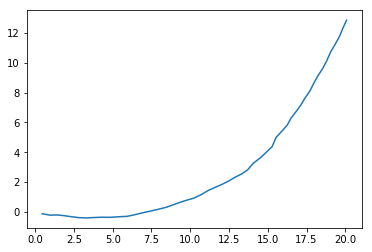

In [16]:
plt.plot(coord1[::2], coord1[1::2])

In [17]:
from scipy import signal
 
#バターワースフィルタ（ローパス）
def lowpass(x, samplerate, fp, fs, gpass, gstop):
    fn = samplerate / 2                           #ナイキスト周波数
    wp = fp / fn                                  #ナイキスト周波数で通過域端周波数を正規化
    ws = fs / fn                                  #ナイキスト周波数で阻止域端周波数を正規化
    N, Wn = signal.buttord(wp, ws, gpass, gstop)  #オーダーとバターワースの正規化周波数を計算
    b, a = signal.butter(N, Wn, "low")            #フィルタ伝達関数の分子と分母を計算
    y = signal.filtfilt(b, a, x)                  #信号に対してフィルタをかける
    return y                                      #フィルタ後の信号を返す

In [20]:
samplerate = 128 
fp = 12       #通過域端周波数[Hz]
fs = 24       #阻止域端周波数[Hz]
gpass = 3       #通過域端最大損失[dB]
gstop = 40      #阻止域端最小損失[dB]

In [21]:
filt_coord1 = [0] * len(coord1)
 
filt_coord1[::2] = lowpass(coord1[::2], samplerate, fp, fs, gpass, gstop)
filt_coord1[1::2] = lowpass(coord1[1::2], samplerate, fp, fs, gpass, gstop)

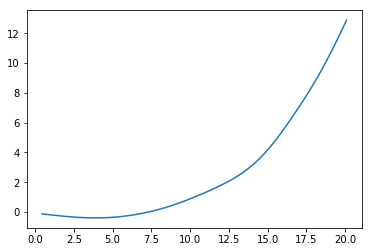

In [22]:
plt.plot(filt_coord1[::2], filt_coord1[1::2])

In [23]:
total_count = 0

for j in tqdm(range(len(output1))):
    for i in range(3):
        coord = outputs[i].iloc[j].values
        filt_coord = [0] * len(coord)
        filt_coord[::2] = lowpass(coord[::2], samplerate, fp, fs, gpass, gstop)
        filt_coord[1::2] = lowpass(coord[1::2], samplerate, fp, fs, gpass, gstop)
        outputs[i].iloc[j] = filt_coord
    
# for i, (key, ground_truth_value) in tqdm(enumerate(ground_truth.items())):


100%|██████████| 71122/71122 [04:28<00:00, 265.36it/s]


In [24]:
output.loc[:, 'conf_0':'conf_2'] = conf
output.loc[:, 'coord_x00':'coord_y049'] = outputs[0]
output.loc[:, 'coord_x10':'coord_y149'] = outputs[1]
output.loc[:, 'coord_x20':'coord_y249'] = outputs[2]
output.head(10)

,timestamp,track_id,conf_0,conf_1,conf_2,coord_x00,coord_y00,coord_x01,coord_y01,coord_x02,...,coord_x245,coord_y245,coord_x246,coord_y246,coord_x247,coord_y247,coord_x248,coord_y248,coord_x249,coord_y249
0,1578606007801600134,2,0.300563,0.089953,0.609484,-0.061408,0.199644,-0.150269,0.390265,-0.238218,...,-1.947545,4.400125,-1.976672,4.488697,-2.006389,4.587524,-2.036443,4.694088,-2.066677,4.804598
1,1578606032802467516,4,0.435640,0.176876,0.387484,-0.582073,-0.938733,-1.192208,-1.893659,-1.800780,...,-22.343081,-42.332354,-22.733967,-43.252842,-23.126687,-44.178341,-23.518983,-45.102637,-23.906985,-46.017041
2,1578606032802467516,5,0.479200,0.368297,0.152503,0.128301,0.201335,0.269814,0.396597,0.408333,...,5.693808,8.190329,5.961183,8.579263,6.238265,8.978835,6.521453,9.384515,6.806190,9.790954
3,1578606032802467516,81,0.363521,0.081219,0.555260,-0.225264,-0.381793,-0.465631,-0.676903,-0.704449,...,-2.415915,-2.966585,-2.423252,-2.945077,-2.429897,-2.918074,-2.436287,-2.886608,-2.442581,-2.852757
4,1578606032802467516,130,0.045740,0.006844,0.947416,0.016481,0.007729,0.022844,-0.001145,0.029765,...,-0.007558,-0.038268,-0.007867,-0.044014,-0.010601,-0.048629,-0.015375,-0.052187,-0.021341,-0.055010
5,1578606057802432986,1,0.409003,0.188232,0.402765,0.682744,1.062996,1.407541,2.136339,2.133222,...,31.847493,47.584185,32.533767,48.615515,33.222973,49.652550,33.910731,50.688172,34.590904,51.712650
6,1578606082801997166,1,0.507322,0.211696,0.280982,0.688131,1.095813,1.408908,2.191805,2.130927,...,31.040672,46.785522,31.686889,47.760486,32.334821,48.740424,32.980577,49.718707,33.618653,50.686148
7,1578606082801997166,707,0.172325,0.113071,0.714604,0.017123,-0.008334,0.008089,0.016713,-0.001782,...,-0.050453,1.163832,-0.057872,1.247598,-0.063333,1.332106,-0.067049,1.416516,-0.069630,1.500246
8,1578606107802708166,1,0.470920,0.207355,0.321725,-0.828370,0.518519,-1.675210,1.065611,-2.523797,...,-37.460903,24.329854,-38.274253,24.849183,-39.091664,25.368570,-39.907638,25.885127,-40.714711,26.394876
9,1578606132802907546,1,0.410924,0.165326,0.423750,-0.944058,0.578252,-1.892920,1.179060,-2.843697,...,-39.126353,24.856734,-39.853644,25.311262,-40.581404,25.765138,-41.305398,26.216275,-42.019542,26.661139


In [187]:
# output.head(20)

In [188]:
# outs = []
# for i in tqdm(range(len(output))):
# # for i, (key, ground_truth_value) in tqdm(enumerate(ground_truth.items())):
#     out = output.iloc[i]
#     conf_0 = output['conf_0'][i]
#     if(conf_0 == 1):
#         outs.append(out)


In [25]:
output.to_csv(str(OUTPUT_DIR)+'sub1105.csv', index=False)

ベース:  21.29347333882463
samplerate = 128 
fp = 12       #通過域端周波数[Hz]
fs = 24       #阻止域端周波数[Hz]
gpass = 3       #通過域端最大損失[dB]
gstop = 40      #阻止域端最小損失[dB]
21.284475049342316

samplerate = 512 
fp = 48       #通過域端周波数[Hz]
fs = 96       #阻止域端周波数[Hz]
gpass = 3       #通過域端最大損失[dB]
gstop = 20      #阻止域端最小損失[dB]
21.291773918893053

samplerate = 512 
fp = 48       #通過域端周波数[Hz]
fs = 96       #阻止域端周波数[Hz]
gpass = 3       #通過域端最大損失[dB]
gstop = 60      #阻止域端最小損失[dB]
21.292450470577933

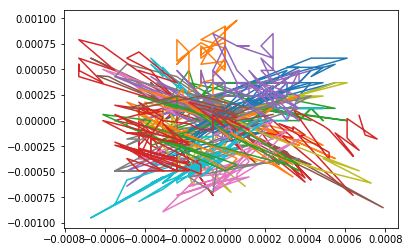

In [123]:
for i in range(len(gt_coords)):
    gt_coord = gt_coords[i]
    plt.plot(gt_coord[::2], gt_coord[1::2])

In [120]:
gt_coord.shape

(99,)